<a href="https://colab.research.google.com/github/YTW0415/Kaggle_Basketball/blob/main/Kaggle_basket_20230301v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Github 연동 관련 주소

https://heytech.tistory.com/393

In [86]:
!mkdir Test

mkdir: cannot create directory ‘Test’: File exists


In [87]:
cd /content/Test/

/content/Test


In [88]:
!git clone https://github.com/YTW0415/Kaggle_Basketball.git

fatal: destination path 'Kaggle_Basketball' already exists and is not an empty directory.


In [89]:
cd Kaggle_Basketball

/content/Test/Kaggle_Basketball


In [90]:
!git config --global user.name 'YTW0415'
!git config --global user.email 'ytaewon0415@gmail.com'

In [91]:
!git status

On branch main
Your branch is ahead of 'origin/main' by 1 commit.
  (use "git push" to publish your local commits)

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	logs.log
	submission.csv

nothing added to commit but untracked files present (use "git add" to track)


In [92]:
!git add qds.txt
!git commit -m "Connect Google Colab and Drive"

On branch main
Your branch is ahead of 'origin/main' by 1 commit.
  (use "git push" to publish your local commits)

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	logs.log
	submission.csv

nothing added to commit but untracked files present (use "git add" to track)


In [93]:
!git push -u origin main

fatal: could not read Username for 'https://github.com': No such device or address


### Base line 2021 2nd place

# Adapting the 2nd Place Solution of the 2021 NCAAW Competition

- Solution write-up is available here : https://www.kaggle.com/c/ncaaw-march-mania-2021/discussion/230705
- 2nd place code : https://www.kaggle.com/theoviel/2nd-place-ncaaw-2021?scriptVersionId=58780991
- It was adapted from this notebook : https://www.kaggle.com/theoviel/ncaa-starter-the-simpler-the-better 

**Changes :**
- Build one model for both Men and Women
- Update metric to MSE

In [94]:
import os
import re
import sklearn
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.metrics import *
from sklearn.linear_model import *
from sklearn.model_selection import *

pd.set_option('display.max_columns', None)

In [95]:
DATA_PATH = '/content/Kaggle_Basketball/march-machine-learning-mania-2023/'

for filename in sorted(os.listdir(DATA_PATH)):
    print(filename)

Cities.csv
Conferences.csv
MConferenceTourneyGames.csv
MGameCities.csv
MMasseyOrdinals.csv
MNCAATourneyCompactResults.csv
MNCAATourneyDetailedResults.csv
MNCAATourneySeedRoundSlots.csv
MNCAATourneySeeds.csv
MNCAATourneySlots.csv
MRegularSeasonCompactResults.csv
MRegularSeasonDetailedResults.csv
MSeasons.csv
MSecondaryTourneyCompactResults.csv
MSecondaryTourneyTeams.csv
MTeamCoaches.csv
MTeamConferences.csv
MTeamSpellings.csv
MTeams.csv
SampleSubmission2023.csv
WGameCities.csv
WNCAATourneyCompactResults.csv
WNCAATourneyDetailedResults.csv
WNCAATourneySeeds.csv
WNCAATourneySlots.csv
WRegularSeasonCompactResults.csv
WRegularSeasonDetailedResults.csv
WSeasons.csv
WTeamConferences.csv
WTeamSpellings.csv
WTeams.csv


# Data preparation

## Seeds
> This file identifies the seeds for all teams in each NCAA® tournament, for all seasons of historical data. Thus, there are between 64-68 rows for each year, depending on whether there were any play-in games and how many there were. In recent years the structure has settled at 68 total teams, with four "play-in" games leading to the final field of 64 teams entering Round 1 on Thursday of the first week (by definition, that is DayNum=136 each season). We will not know the seeds of the respective tournament teams, or even exactly which 68 teams it will be, until Selection Sunday on March 15, 2020 (DayNum=132).

> The seed is a 3/4-character :
- First character : Region (W, X, Y, or Z)
- Next two digits : Seed within the region (01 to 16)
- Last character (optional): Distinguishes teams between play-ins ( a or b)

In [96]:
df_seeds = pd.concat([
    pd.read_csv(DATA_PATH + "MNCAATourneySeeds.csv"),
    pd.read_csv(DATA_PATH + "WNCAATourneySeeds.csv"),
], ignore_index=True)
    
df_seeds.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


In [97]:
df_seeds['Seed'].value_counts()

W01     61
X14     61
Y01     61
Y02     61
Y03     61
        ..
Z13a     1
Z13b     1
Y12a     1
Y12b     1
Z14b     1
Name: Seed, Length: 90, dtype: int64

## Season results
> This file identifies the game-by-game results for many seasons of historical data, starting with the 1985 season (the first year the NCAA® had a 64-team tournament). For each season, the file includes all games played from DayNum 0 through 132. It is important to realize that the "Regular Season" games are simply defined to be all games played on DayNum=132 or earlier (DayNum=132 is Selection Sunday, and there are always a few conference tournament finals actually played early in the day on Selection Sunday itself). Thus a game played on or before Selection Sunday will show up here whether it was a pre-season tournament, a non-conference game, a regular conference game, a conference tournament game, or whatever.

In [98]:
df_season_results = pd.concat([
    pd.read_csv(DATA_PATH + "MRegularSeasonCompactResults.csv"),
    pd.read_csv(DATA_PATH + "WRegularSeasonCompactResults.csv"),
], ignore_index=True)

df_season_results.drop(['NumOT', 'WLoc'], axis=1, inplace=True)

In [99]:
df_season_results['ScoreGap'] = df_season_results['WScore'] - df_season_results['LScore']

In [100]:
df_season_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,ScoreGap
0,1985,20,1228,81,1328,64,17
1,1985,25,1106,77,1354,70,7
2,1985,25,1112,63,1223,56,7
3,1985,25,1165,70,1432,54,16
4,1985,25,1192,86,1447,74,12


### Features 
For each team at each season, I compute : 
- Number of wins
- Number of losses
- Average score gap of wins
- Average score gap of losses

And use the following features : 
- Win Ratio
- Average score gap

In [101]:
num_win = df_season_results.groupby(['Season', 'WTeamID']).count()
num_win = num_win.reset_index()[['Season', 'WTeamID', 'DayNum']].rename(columns={"DayNum": "NumWins", "WTeamID": "TeamID"})

In [102]:
num_loss = df_season_results.groupby(['Season', 'LTeamID']).count()
num_loss = num_loss.reset_index()[['Season', 'LTeamID', 'DayNum']].rename(columns={"DayNum": "NumLosses", "LTeamID": "TeamID"})

In [103]:
gap_win = df_season_results.groupby(['Season', 'WTeamID']).mean().reset_index()
gap_win = gap_win[['Season', 'WTeamID', 'ScoreGap']].rename(columns={"ScoreGap": "GapWins", "WTeamID": "TeamID"})

In [104]:
gap_loss = df_season_results.groupby(['Season', 'LTeamID']).mean().reset_index()
gap_loss = gap_loss[['Season', 'LTeamID', 'ScoreGap']].rename(columns={"ScoreGap": "GapLosses", "LTeamID": "TeamID"})

Merge

In [105]:
df_features_season_w = df_season_results.groupby(['Season', 'WTeamID']).count().reset_index()[['Season', 'WTeamID']].rename(columns={"WTeamID": "TeamID"})
df_features_season_l = df_season_results.groupby(['Season', 'LTeamID']).count().reset_index()[['Season', 'LTeamID']].rename(columns={"LTeamID": "TeamID"})

In [106]:
df_features_season = pd.concat([df_features_season_w, df_features_season_l], axis=0).drop_duplicates().sort_values(['Season', 'TeamID']).reset_index(drop=True)

In [107]:
df_features_season = df_features_season.merge(num_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(num_loss, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(gap_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(gap_loss, on=['Season', 'TeamID'], how='left')

In [108]:
df_features_season.fillna(0, inplace=True)  

In [109]:
df_features_season

,Season,TeamID,NumWins,NumLosses,GapWins,GapLosses
0,1985,1102,5.0,19.0,10.000000,9.947368
1,1985,1103,9.0,14.0,7.555556,9.857143
2,1985,1104,21.0,9.0,13.190476,4.777778
3,1985,1106,10.0,14.0,9.500000,13.285714
4,1985,1108,19.0,6.0,13.842105,10.666667
...,...,...,...,...,...,...
21423,2023,3473,1.0,22.0,9.000000,19.318182
21424,2023,3474,5.0,18.0,10.200000,19.888889
21425,2023,3475,8.0,16.0,13.875000,11.625000
21426,2023,3476,7.0,19.0,10.571429,13.368421


Compute features

In [110]:
df_features_season['WinRatio'] = df_features_season['NumWins'] / (df_features_season['NumWins'] + df_features_season['NumLosses'])
df_features_season['GapAvg'] = (
    (df_features_season['NumWins'] * df_features_season['GapWins'] - 
    df_features_season['NumLosses'] * df_features_season['GapLosses'])
    / (df_features_season['NumWins'] + df_features_season['NumLosses'])
)

In [111]:
df_features_season.drop(['NumWins', 'NumLosses', 'GapWins', 'GapLosses'], axis=1, inplace=True)

## Tourney results

> This file identifies the game-by-game NCAA® tournament results for all seasons of historical data. The data is formatted exactly like the MRegularSeasonCompactResults data. All games will show up as neutral site (so WLoc is always N). Note that this tournament game data also includes the play-in games (which always occurred on day 134/135) for those years that had play-in games. Thus each season you will see between 63 and 67 games listed, depending on how many play-in games there were.

In [112]:
df_tourney_results = pd.concat([
    pd.read_csv(DATA_PATH + "WNCAATourneyCompactResults.csv"),
    pd.read_csv(DATA_PATH + "MNCAATourneyCompactResults.csv"),
], ignore_index=True)
df_tourney_results.drop(['NumOT', 'WLoc'], axis=1, inplace=True)

In [113]:
df_tourney_results

,Season,DayNum,WTeamID,WScore,LTeamID,LScore
0,1998,137,3104,94,3422,46
1,1998,137,3112,75,3365,63
2,1998,137,3163,93,3193,52
3,1998,137,3198,59,3266,45
4,1998,137,3203,74,3208,72
...,...,...,...,...,...,...
3895,2022,146,1242,76,1274,50
3896,2022,146,1314,69,1389,49
3897,2022,152,1242,81,1437,65
3898,2022,152,1314,81,1181,77


## FiveThirtyEight Ratings
> Not available yet !

In [114]:
# df_538 = pd.read_csv("../input/ncaa-men-538-team-ratings/538ratingsMen.csv")
# df_538.drop('TeamName', axis=1, inplace=True)
# df_538.head()

# Feature Engineering

## Train data

In [331]:
df = df_tourney_results.copy()
df = df[df['Season'] >= 1999].reset_index(drop=True)

df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore
0,1999,137,3104,80,3212,68
1,1999,137,3112,87,3196,84
2,1999,137,3155,76,3197,45
3,1999,137,3161,71,3169,59
4,1999,137,3163,97,3384,46


### Seeds
- `SeedW` is the seed of the winning team
- `SeedL` is the seed of the losing team

In [332]:
df = pd.merge(
    df, 
    df_seeds, 
    how='left', 
    left_on=['Season', 'WTeamID'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedW'})

In [333]:
df = pd.merge(
    df, 
    df_seeds, 
    how='left', 
    left_on=['Season', 'LTeamID'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedL'})

In [334]:
def treat_seed(seed):
    return int(re.sub("[^0-9]", "", seed))

In [335]:
df['SeedW'] = df['SeedW'].apply(treat_seed)
df['SeedL'] = df['SeedL'].apply(treat_seed)

In [336]:
df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,SeedW,SeedL
0,1999,137,3104,80,3212,68,5,12
1,1999,137,3112,87,3196,84,6,11
2,1999,137,3155,76,3197,45,2,15
3,1999,137,3161,71,3169,59,2,15
4,1999,137,3163,97,3384,46,1,16


### Season Stats
- `WinRatioW` is the win ratio of the winning team during the season
- `WinRatioL` is the win ratio of the losing team during the season

In [337]:
df = pd.merge(
    df,
    df_features_season,
    how='left',
    left_on=['Season', 'WTeamID'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsW',
    'NumLosses': 'NumLossesW',
    'GapWins': 'GapWinsW',
    'GapLosses': 'GapLossesW',
    'WinRatio': 'WinRatioW',
    'GapAvg': 'GapAvgW',
}).drop(columns='TeamID', axis=1)

In [338]:
df = pd.merge(
    df,
    df_features_season,
    how='left',
    left_on=['Season', 'LTeamID'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsL',
    'NumLosses': 'NumLossesL',
    'GapWins': 'GapWinsL',
    'GapLosses': 'GapLossesL',
    'WinRatio': 'WinRatioL',
    'GapAvg': 'GapAvgL',
}).drop(columns='TeamID', axis=1)

In [339]:
df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,SeedW,SeedL,WinRatioW,GapAvgW,WinRatioL,GapAvgL
0,1999,137,3104,80,3212,68,5,12,0.655172,10.551724,0.857143,17.071429
1,1999,137,3112,87,3196,84,6,11,0.629630,4.481481,0.593750,4.968750
2,1999,137,3155,76,3197,45,2,15,0.827586,14.931034,0.620690,4.413793
3,1999,137,3161,71,3169,59,2,15,0.939394,17.818182,0.750000,9.642857
4,1999,137,3163,97,3384,46,1,16,0.870968,31.032258,0.620690,2.344828


### FiveThirtyEight Ratings
- `538ratingW` is the rating of the winning team during the season
- `538ratingL` is the rating of the losing team during the season

In [340]:
# df = pd.merge(
#     df,
#     df_538,
#     how='left',
#     left_on=['Season', 'WTeamID'],
#     right_on=['Season', 'TeamID']
# ).drop('TeamID', axis=1).rename(columns={'538rating': '538ratingW'})

In [341]:
# df = pd.merge(
#     df, 
#     df_538, 
#     how='left', 
#     left_on=['Season', 'LTeamID'], 
#     right_on=['Season', 'TeamID']
# ).drop('TeamID', axis=1).rename(columns={'538rating': '538ratingL'})

In [342]:
# df.head()

### Add symetrical
- Right now our data only consists of won matches
- We duplicate our data, get rid of the winner loser 

In [343]:
def add_loosing_matches(df):
    win_rename = {
        "WTeamID": "TeamIdA", 
        "WScore" : "ScoreA", 
        "LTeamID" : "TeamIdB",
        "LScore": "ScoreB",
     }
    win_rename.update({c : c[:-1] + "A" for c in df.columns if c.endswith('W')})
    win_rename.update({c : c[:-1] + "B" for c in df.columns if c.endswith('L')})
    
    lose_rename = {
        "WTeamID": "TeamIdB", 
        "WScore" : "ScoreB", 
        "LTeamID" : "TeamIdA",
        "LScore": "ScoreA",
    }
    lose_rename.update({c : c[:-1] + "B" for c in df.columns if c.endswith('W')})
    lose_rename.update({c : c[:-1] + "A" for c in df.columns if c.endswith('L')})
    
    win_df = df.copy()
    lose_df = df.copy()
    
    win_df = win_df.rename(columns=win_rename)
    lose_df = lose_df.rename(columns=lose_rename)
    
    return pd.concat([win_df, lose_df], axis=0, sort=False)

In [344]:
df = add_loosing_matches(df)

In [345]:
df

,Season,DayNum,TeamIdA,ScoreA,TeamIdB,ScoreB,SeedA,SeedB,WinRatioA,GapAvgA,WinRatioB,GapAvgB
0,1999,137,3104,80,3212,68,5,12,0.655172,10.551724,0.857143,17.071429
1,1999,137,3112,87,3196,84,6,11,0.629630,4.481481,0.593750,4.968750
2,1999,137,3155,76,3197,45,2,15,0.827586,14.931034,0.620690,4.413793
3,1999,137,3161,71,3169,59,2,15,0.939394,17.818182,0.750000,9.642857
4,1999,137,3163,97,3384,46,1,16,0.870968,31.032258,0.620690,2.344828
...,...,...,...,...,...,...,...,...,...,...,...,...
2950,2022,146,1274,50,1242,76,10,1,0.696970,3.787879,0.823529,10.441176
2951,2022,146,1389,49,1314,69,15,8,0.620690,3.931034,0.727273,5.787879
2952,2022,152,1437,65,1242,81,2,1,0.787879,9.545455,0.823529,10.441176
2953,2022,152,1181,77,1314,81,2,8,0.823529,13.029412,0.727273,5.787879


### Differences
- We compute the difference between the team for each feature.
- This helps further assessing how better (or worse) team A is from team B

In [346]:
cols_to_diff = [
    'Seed', 'WinRatio', 'GapAvg', # '538rating'
]

for col in cols_to_diff:
    df[col + 'Diff'] = df[col + 'A'] - df[col + 'B']

## Test Data

### Preparing

In [347]:
df_test = pd.read_csv(DATA_PATH + "SampleSubmission2023.csv")

In [348]:
df_test['Season'] = df_test['ID'].apply(lambda x: int(x.split('_')[0]))
df_test['TeamIdA'] = df_test['ID'].apply(lambda x: int(x.split('_')[1]))
df_test['TeamIdB'] = df_test['ID'].apply(lambda x: int(x.split('_')[2]))

In [349]:
df_test

,ID,Pred,Season,TeamIdA,TeamIdB
0,2023_1101_1102,0.5,2023,1101,1102
1,2023_1101_1103,0.5,2023,1101,1103
2,2023_1101_1104,0.5,2023,1101,1104
3,2023_1101_1105,0.5,2023,1101,1105
4,2023_1101_1106,0.5,2023,1101,1106
...,...,...,...,...,...
130678,2023_3474_3476,0.5,2023,3474,3476
130679,2023_3474_3477,0.5,2023,3474,3477
130680,2023_3475_3476,0.5,2023,3475,3476
130681,2023_3475_3477,0.5,2023,3475,3477


### Seeds
- Seeds are not released yet, so I fill missing values with "W01"

In [350]:
df_test = pd.merge(
    df_test,
    df_seeds,
    how='left',
    left_on=['Season', 'TeamIdA'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedA'}).fillna('W01')

In [351]:
df_test = pd.merge(
    df_test, 
    df_seeds, 
    how='left', 
    left_on=['Season', 'TeamIdB'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedB'}).fillna('W01')

In [352]:
df_test['SeedA'] = df_test['SeedA'].apply(treat_seed)
df_test['SeedB'] = df_test['SeedB'].apply(treat_seed)

### Season Stats

In [353]:
df_test = pd.merge(
    df_test,
    df_features_season,
    how='left',
    left_on=['Season', 'TeamIdA'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsA',
    'NumLosses': 'NumLossesA',
    'GapWins': 'GapWinsA',
    'GapLosses': 'GapLossesA',
    'WinRatio': 'WinRatioA',
    'GapAvg': 'GapAvgA',
}).drop(columns='TeamID', axis=1)

In [354]:
df_test = pd.merge(
    df_test,
    df_features_season,
    how='left',
    left_on=['Season', 'TeamIdB'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsB',
    'NumLosses': 'NumLossesB',
    'GapWins': 'GapWinsB',
    'GapLosses': 'GapLossesB',
    'WinRatio': 'WinRatioB',
    'GapAvg': 'GapAvgB',
}).drop(columns='TeamID', axis=1)

### Ratings

In [355]:
# df_test = pd.merge(
#     df_test,
#     df_538,
#     how='left',
#     left_on=['Season', 'TeamIdA'],
#     right_on=['Season', 'TeamID']
# ).drop('TeamID', axis=1).rename(columns={'538rating': '538ratingA'})

In [356]:
# df_test = pd.merge(
#     df_test,
#     df_538,
#     how='left',
#     left_on=['Season', 'TeamIdB'],
#     right_on=['Season', 'TeamID']
# ).drop('TeamID', axis=1).rename(columns={'538rating': '538ratingB'})

### Differences

In [357]:
for col in cols_to_diff:
    df_test[col + 'Diff'] = df_test[col + 'A'] - df_test[col + 'B']

## Target

In [358]:
df['ScoreDiff'] = df['ScoreA'] - df['ScoreB']
df['WinA'] = (df['ScoreDiff'] > 0).astype(int)

# Modeling

In [359]:
features = [
    "SeedA", "SeedB", 'WinRatioA', 'GapAvgA', 'WinRatioB', 'GapAvgB', 'SeedDiff', 'WinRatioDiff', 'GapAvgDiff'
]

In [360]:
# features = [
#     'SeedDiff',
# #     '538ratingDiff',
#     'WinRatioDiff', 
#     'GapAvgDiff', 
# ]

In [361]:
def rescale(features, df_train, df_val, df_test=None):
    min_ = df_train[features].min()
    max_ = df_train[features].max()
    
    df_train[features] = (df_train[features] - min_) / (max_ - min_)
    df_val[features] = (df_val[features] - min_) / (max_ - min_)
    
    if df_test is not None:
        df_test[features] = (df_test[features] - min_) / (max_ - min_)
        
    return df_train, df_val, df_test

### Cross Validation
- Validate on season `n`, for `n` in the 3 last seasons. 
- Train on earlier seasons. First available season is 2016 because of the FiveThirtyEight ratings.
- Pipeline support classification (predict the team that wins) and regression (predict the score gap), but classification worked better on CV.

### Baseline은 엘라스틱넷 회귀, 로지스틱 회귀

In [362]:
def kfold(df, df_test_=None, plot=False, verbose=0, mode="reg"):
    seasons = df['Season'].unique()
    cvs = []
    pred_tests = []
    target = "ScoreDiff" if mode == "reg" else "WinA"
    
    for season in seasons[1:]:
        if verbose:
            print(f'\nValidating on season {season}')
        
        df_train = df[df['Season'] < season].reset_index(drop=True).copy()
        df_val = df[df['Season'] == season].reset_index(drop=True).copy()
        df_test = df_test_.copy()
        
        df_train, df_val, df_test = rescale(features, df_train, df_val, df_test)
        
        if mode == "reg":
#             model = LinearRegression()
            model = ElasticNet(alpha=1, l1_ratio=0.5)
        else:
            model = LogisticRegression(C=1)

        model.fit(df_train[features], df_train[target])
        
        if mode == "reg":
            pred = model.predict(df_val[features])
        else:
            pred = model.predict_proba(df_val[features])[:, 1]
        
        if df_test is not None:
            if mode == "reg":
                pred_test = model.predict(df_test[features])
                
#                 print( pred_test.max() - pred_test.min())
                pred_test = (pred_test - pred_test.min()) / (pred_test.max() - pred_test.min())
            else:
                pred_test = model.predict_proba(df_test[features])[:, 1]
                
            pred_tests.append(pred_test)
            
        if plot:
            plt.figure(figsize=(15, 6))
            plt.subplot(1, 2, 1)
            plt.scatter(pred, df_val['ScoreDiff'].values, s=5)
            plt.title('Prediction vs Score Diff')
            plt.grid(True)
            plt.subplot(1, 2, 2)
            sns.histplot(pred, bins=20)
            plt.title('Predictions probability repartition')
            plt.show()
        
        pred = (pred - pred.min()) / (pred.max() - pred.min())
        pred = np.clip(pred, 0, 1)

        score = ((df_val['WinA'].values - pred) ** 2).mean()
        cvs.append(score)

        if verbose:
            print(f'\t -> Scored {score:.3f}')
        
    print(f'\n Local CV is {np.mean(cvs):.3f}')
    
    return pred_tests


Validating on season 2000


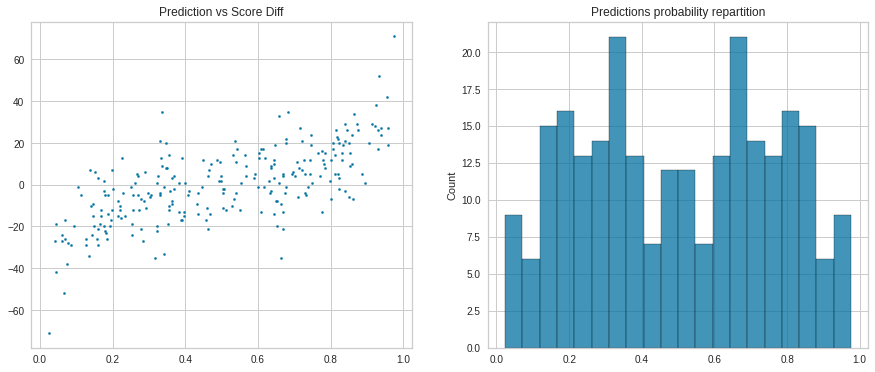

	 -> Scored 0.171

Validating on season 2001


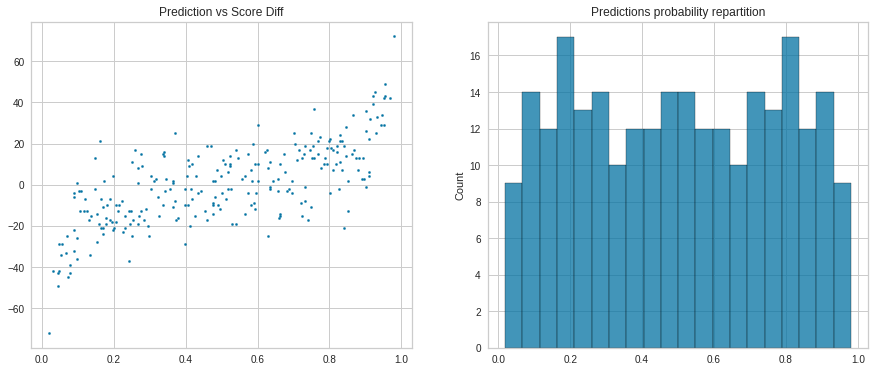

	 -> Scored 0.171

Validating on season 2002


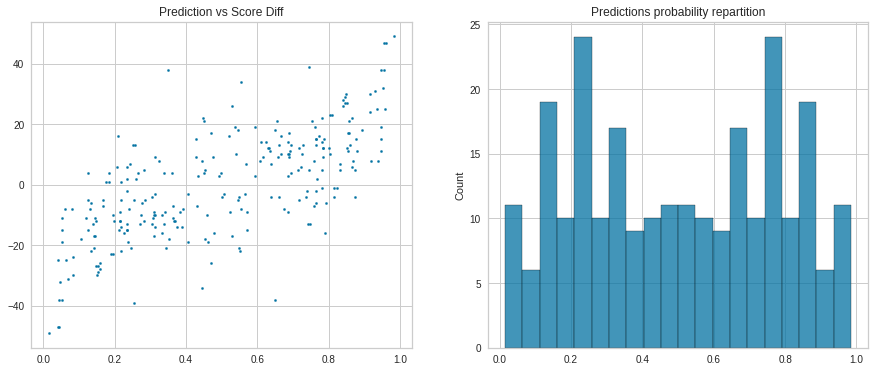

	 -> Scored 0.167

Validating on season 2003


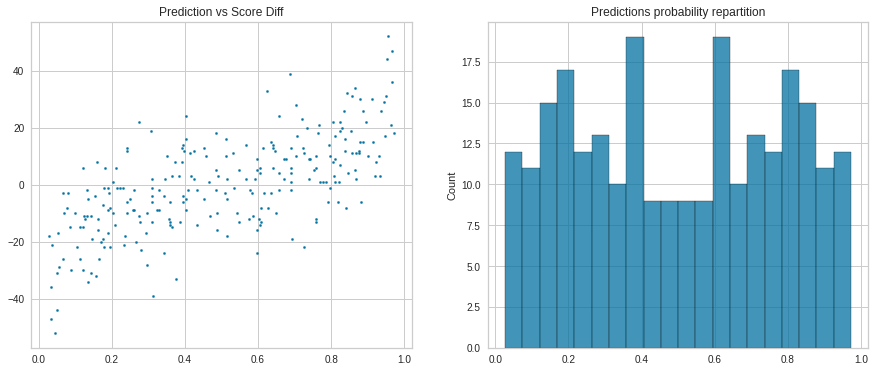

	 -> Scored 0.154

Validating on season 2004


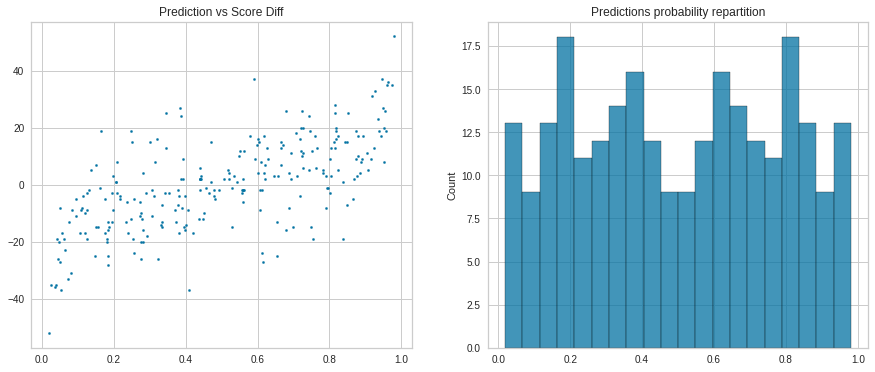

	 -> Scored 0.160

Validating on season 2005


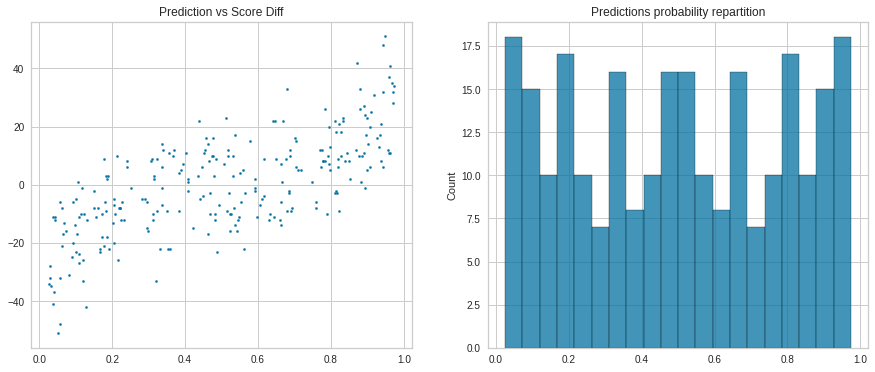

	 -> Scored 0.168

Validating on season 2006


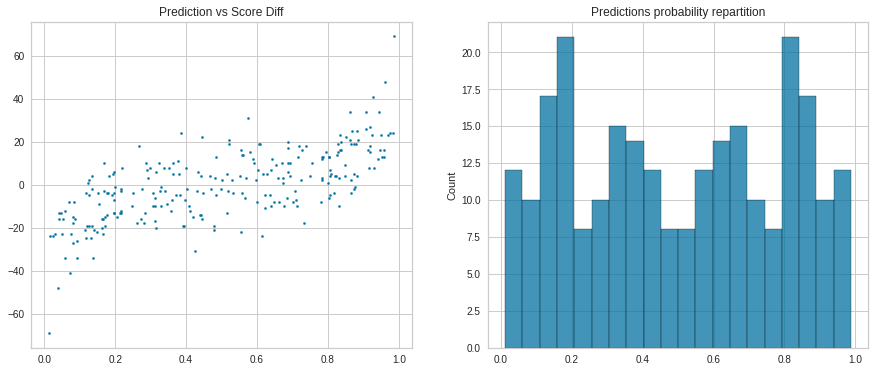

	 -> Scored 0.163

Validating on season 2007


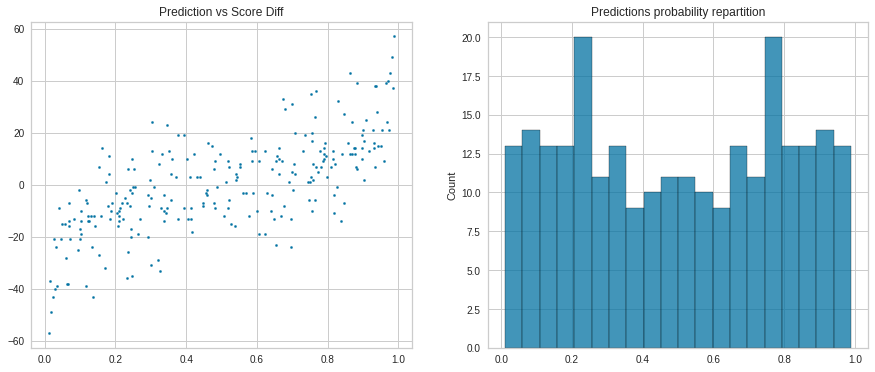

	 -> Scored 0.153

Validating on season 2008


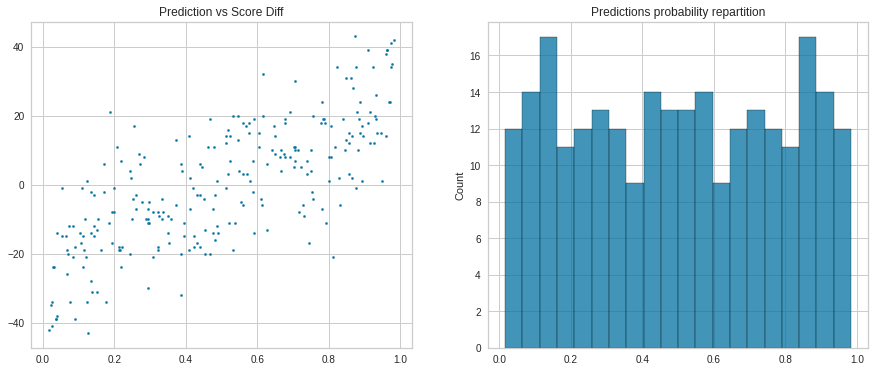

	 -> Scored 0.142

Validating on season 2009


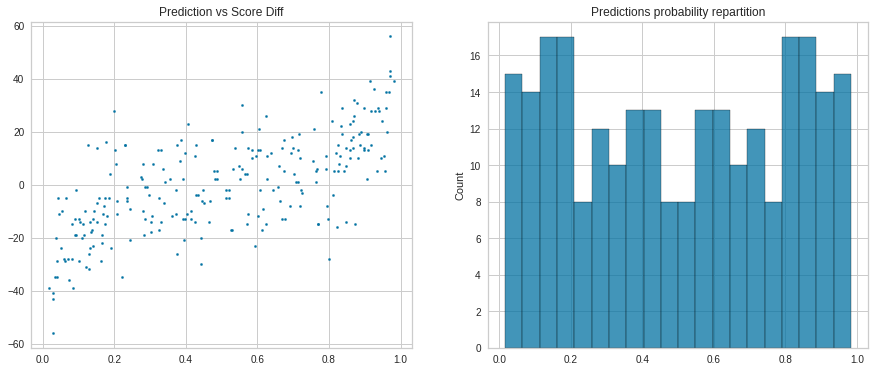

	 -> Scored 0.162

Validating on season 2010


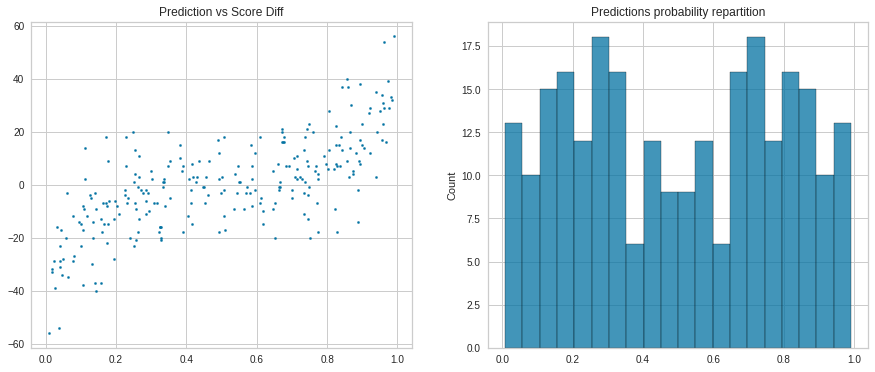

	 -> Scored 0.168

Validating on season 2011


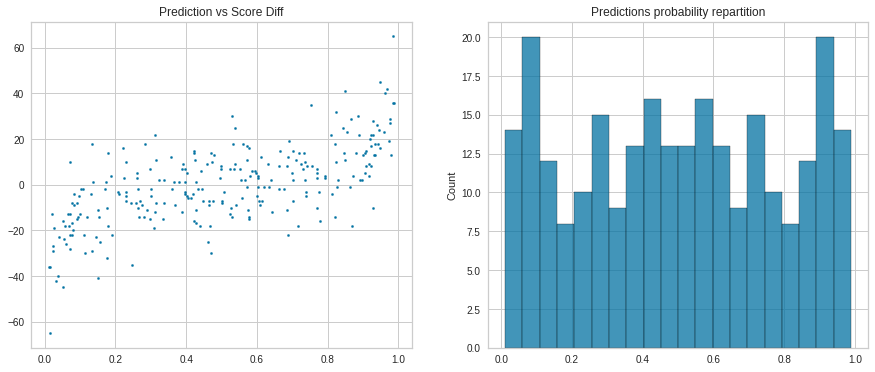

	 -> Scored 0.177

Validating on season 2012


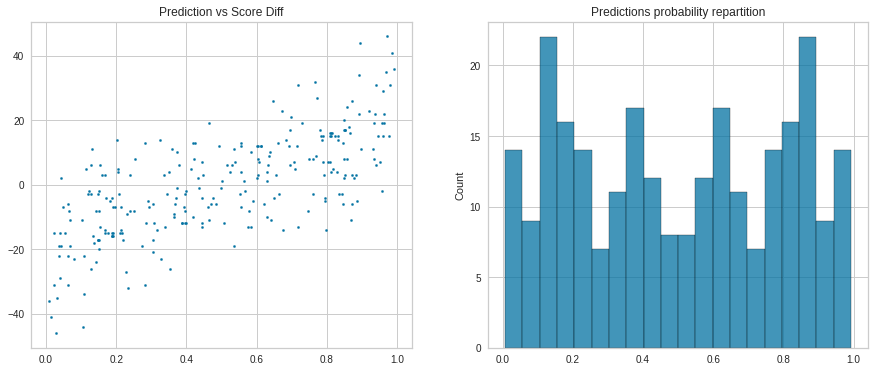

	 -> Scored 0.163

Validating on season 2013


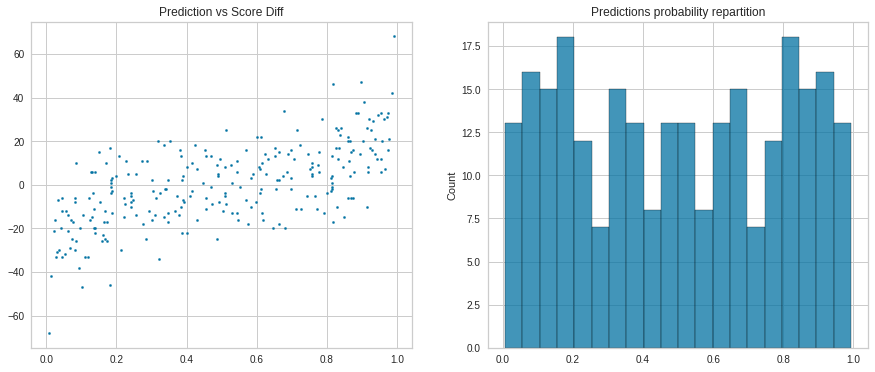

	 -> Scored 0.187

Validating on season 2014


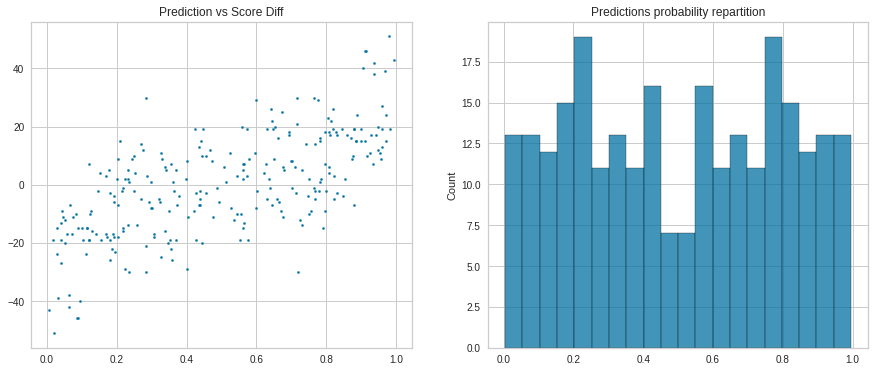

	 -> Scored 0.183

Validating on season 2015


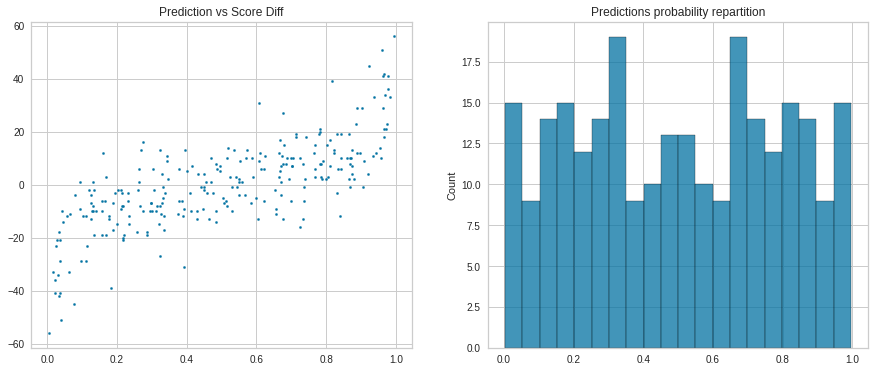

	 -> Scored 0.144

Validating on season 2016


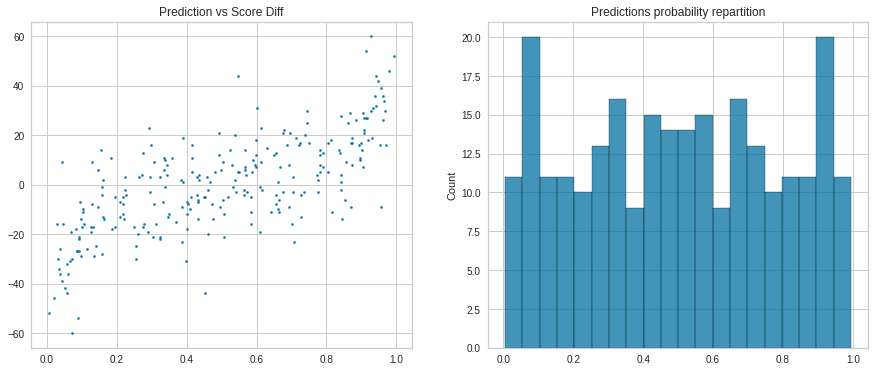

	 -> Scored 0.177

Validating on season 2017


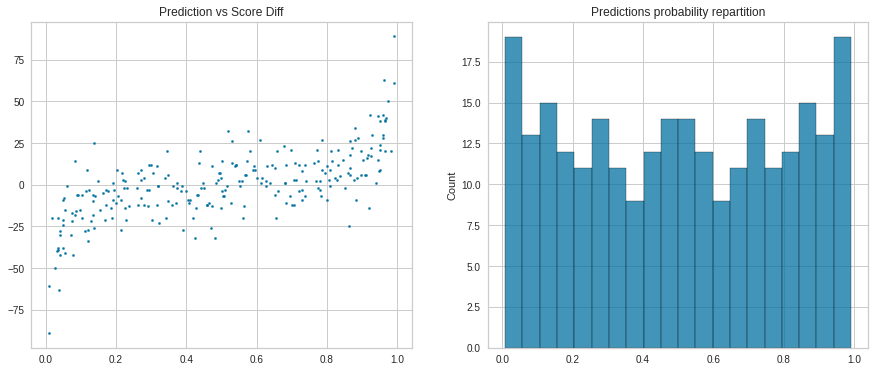

	 -> Scored 0.164

Validating on season 2018


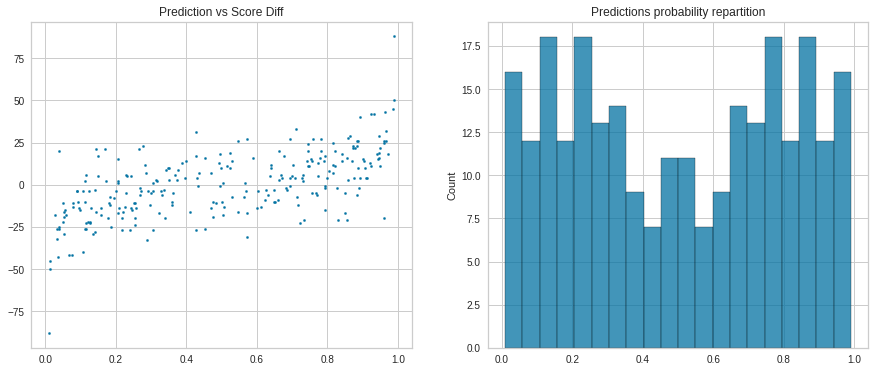

	 -> Scored 0.192

Validating on season 2019


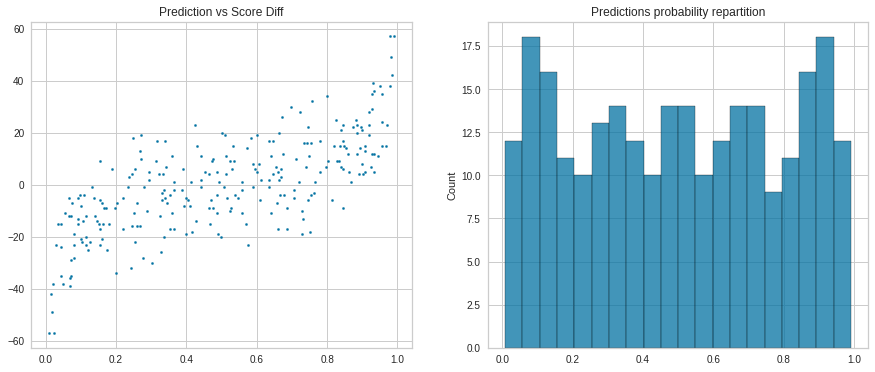

	 -> Scored 0.153

Validating on season 2021


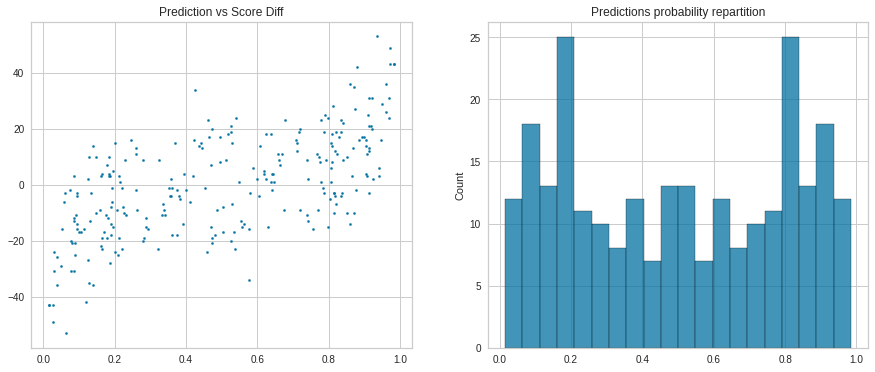

	 -> Scored 0.192

Validating on season 2022


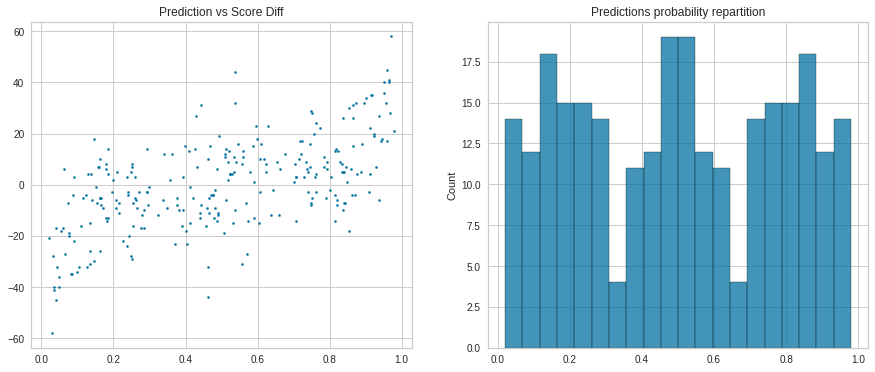

	 -> Scored 0.197

 Local CV is 0.169


In [392]:
pred_tests = kfold(df, df_test, plot=True, verbose=1, mode="cls")

In [364]:
# plot=True
# verbose=1
# mode="cls"
# df_test_ = df_test

# seasons = df['Season'].unique()
# cvs = []
# pred_tests = []
# target = "ScoreDiff" if mode == "reg" else "WinA"

# for season in seasons[1:]:
#     if verbose:
#         print(f'\nValidating on season {season}')
    
#     df_train = df[df['Season'] < season].reset_index(drop=True).copy()
#     df_val = df[df['Season'] == season].reset_index(drop=True).copy()
#     df_test = df_test_.copy()
    
#     df_train, df_val, df_test = rescale(features, df_train, df_val, df_test)
    
#     if mode == "reg":
# #             model = LinearRegression()
#         model = ElasticNet(alpha=1, l1_ratio=0.5)
#     else:
#         model = LogisticRegression(C=1)

#     model.fit(df_train[features], df_train[target])
    
#     if mode == "reg":
#         pred = model.predict(df_val[features])
#     else:
#         pred = model.predict_proba(df_val[features])[:, 1]
    
#     if df_test is not None:
#         if mode == "reg":
#             pred_test = model.predict(df_test[features])
            
# #                 print( pred_test.max() - pred_test.min())
#             pred_test = (pred_test - pred_test.min()) / (pred_test.max() - pred_test.min())
#         else:
#             pred_test = model.predict_proba(df_test[features])[:, 1]
            
#         pred_tests.append(pred_test)
        
#     if plot:
#         plt.figure(figsize=(15, 6))
#         plt.subplot(1, 2, 1)
#         plt.scatter(pred, df_val['ScoreDiff'].values, s=5)
#         plt.title('Prediction vs Score Diff')
#         plt.grid(True)
#         plt.subplot(1, 2, 2)
#         sns.histplot(pred, bins=20)
#         plt.title('Predictions probability repartition')
#         plt.show()
    
#     pred = (pred - pred.min()) / (pred.max() - pred.min())
#     pred = np.clip(pred, 0, 1)

#     score = ((df_val['WinA'].values - pred) ** 2).mean()

#     cvs.append(score)

#     if verbose:
#         print(f'\t -> Scored {score:.3f}')
    
# print(f'\n Local CV is {np.mean(cvs):.3f}')

## Submission

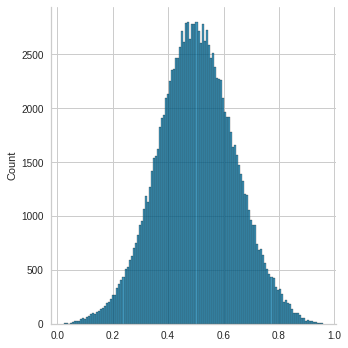

In [365]:
pred_test = np.mean(pred_tests, 0)
df_test['pred'] = pred_test

_ = sns.displot(pred_test)

In [366]:
final_sub = df_test[['ID', 'pred']].copy()
final_sub.to_csv('submission.csv', index=False)

In [367]:
final_sub

,ID,pred
0,2023_1101_1102,0.458909
1,2023_1101_1103,0.401505
2,2023_1101_1104,0.282935
3,2023_1101_1105,0.499288
4,2023_1101_1106,0.593301
...,...,...
130678,2023_3474_3476,0.386283
130679,2023_3474_3477,0.393383
130680,2023_3475_3476,0.557961
130681,2023_3475_3477,0.565228


Done ! 

# AutoML

In [229]:
!pip install --use-deprecated=legacy-resolver pycaret[full]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [230]:
!pip install numba==0.53

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [231]:
!pip uninstall sklearn -y
!pip install --upgrade sklearn
!pip install scikit-learn==0.2 --user

Found existing installation: sklearn 0.0.post1
Uninstalling sklearn-0.0.post1:
  Successfully uninstalled sklearn-0.0.post1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached sklearn-0.0.post1-py3-none-any.whl
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement scikit-learn==0.2 (from versions: 0.9, 0.10, 0.11, 0.12, 0.12.1, 0.13, 0.13.1, 0.14, 0.14.1, 0.15.0, 0.15.1, 0.15.2, 0.16.0, 0.16.1, 0.17, 0.17.1, 0.18, 0.18.1, 0.18.2, 0.19.0, 0.19.1, 0.19.2, 0.20.0, 0.20.1, 0.20.2, 0.20.3, 0.20.4, 0.21.1, 0.21.2, 0.21.3, 0.22, 0.22.1, 0.22.2, 0.22.2.post1, 0.23.0, 0.23.1, 0.23.2, 0.24.0, 0.24.1, 0.24.2, 1.0, 1.0.1, 1.0.2, 1.1.0, 1.1.1, 1.1.2, 1.1.3, 1.2.0rc1, 1.2.0, 1.2.1)
ERROR: No matching distribution found for scikit-learn==0.2


In [368]:
train_df = pd.concat([df[features], df['WinA']],axis=1)

test_df = df_test[features]

In [369]:
test_df

,SeedA,SeedB,WinRatioA,GapAvgA,WinRatioB,GapAvgB,SeedDiff,WinRatioDiff,GapAvgDiff
0,1,1,0.409091,-2.863636,0.482759,0.241379,0,-0.073668,-3.105016
1,1,1,0.409091,-2.863636,0.653846,5.653846,0,-0.244755,-8.517483
2,1,1,0.409091,-2.863636,0.851852,15.111111,0,-0.442761,-17.974747
3,1,1,0.409091,-2.863636,0.360000,-3.560000,0,0.049091,0.696364
4,1,1,0.409091,-2.863636,0.259259,-9.703704,0,0.149832,6.840067
...,...,...,...,...,...,...,...,...,...
130678,1,1,0.217391,-13.347826,0.269231,-6.923077,0,-0.051839,-6.424749
130679,1,1,0.217391,-13.347826,0.423077,-5.000000,0,-0.205686,-8.347826
130680,1,1,0.333333,-3.125000,0.269231,-6.923077,0,0.064103,3.798077
130681,1,1,0.333333,-3.125000,0.423077,-5.000000,0,-0.089744,1.875000


In [371]:
#https://pycaret.readthedocs.io/en/latest/api/regression.html

from pycaret.classification import *

reg_test_1 = setup(data=train_df,   # df 설정
                   target='WinA', # Target 설정
                   train_size= 0.7, # size 설정
                   fold=5,
                   normalize = False,
                   transformation = False,
                   pca = False,
                   #use_gpu = True,
                   #ordinal_features = {'key' : [i for i in range(12)]}'# Fold 설정
                   )


,Description,Value
0,session_id,4570
1,Target,WinA
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(5910, 10)"
5,Missing Values,False
6,Numeric Features,7
7,Categorical Features,2
8,Ordinal Features,False
9,High Cardinality Features,False


INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[], target='WinA',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_strateg...
                ('scaling', 'passthrough'), ('P_transform', 'passthrough'),
                ('binn', 'passthrough'), ('rem_outliers', 'passthrough'),
                ('cluste

In [372]:
#logloss 적용 및 predict_proba로 제출하기 위해 metric 추가
add_metric('logloss', 'LogLoss', log_loss, greater_is_better=False, target="pred_proba")

from sklearn.metrics import brier_score_loss

add_metric('Brier', 'Brier', brier_score_loss, greater_is_better=False, target="pred_proba")

Name                                                             Brier
Display Name                                                     Brier
Score Function           <function brier_score_loss at 0x7f26192920d0>
Scorer               make_scorer(brier_score_loss, greater_is_bette...
Target                                                      pred_proba
Args                                                                {}
Greater is Better                                                False
Multiclass                                                        True
Custom                                                            True
Name: Brier, dtype: object

### Blended Model

In [373]:
#lda 와 nb는 losloss가 좋지만 accuracy, auc가 상대적으로 좋지 않아 커스텀모델 생성

custom_model = compare_models(fold = 5, sort = 'Brier', n_select = 3, exclude=['svm','ridge'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss,Brier,TT (Sec)
lr,Logistic Regression,0.7418,0.8320,0.7482,0.7404,0.7443,0.4835,0.4835,0.4941,0.1668,1.192
lda,Linear Discriminant Analysis,0.7377,0.8318,0.7458,0.7356,0.7406,0.4753,0.4754,0.5007,0.1690,0.078
gbc,Gradient Boosting Classifier,0.7292,0.8216,0.7323,0.7296,0.7309,0.4584,0.4584,0.5068,0.1717,1.288
catboost,CatBoost Classifier,0.7292,0.8233,0.7357,0.7280,0.7318,0.4584,0.4584,0.5088,0.1721,4.784
rf,Random Forest Classifier,0.7154,0.8094,0.7130,0.7183,0.7156,0.4308,0.4310,0.5571,0.1784,0.648
lightgbm,Light Gradient Boosting Machine,0.7239,0.8112,0.7270,0.7243,0.7256,0.4477,0.4478,0.5383,0.1805,0.300
et,Extra Trees Classifier,0.7123,0.8015,0.7135,0.7135,0.7135,0.4246,0.4246,0.6813,0.1863,0.644
xgboost,Extreme Gradient Boosting,0.6990,0.7934,0.7005,0.7002,0.7003,0.3979,0.3980,0.6018,0.1981,0.868
knn,K Neighbors Classifier,0.6912,0.7668,0.6933,0.6925,0.6927,0.3825,0.3827,2.0149,0.2065,0.104
ada,Ada Boost Classifier,0.7200,0.8170,0.7198,0.7219,0.7208,0.4400,0.4400,0.6647,0.2364,0.466


INFO:logs:create_model_container: 14
INFO:logs:master_model_container: 14
INFO:logs:display_container: 2
INFO:logs:[LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=4570, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False), LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001), GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_wei

In [374]:
tuned_top3 = [tune_model(i) for i in custom_model]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss,Brier
Fold,,,,,,,,,
0,0.7476,0.8451,0.7596,0.7435,0.7515,0.4951,0.4952,0.5113,0.1680
1,0.7364,0.8197,0.7524,0.7313,0.7417,0.4727,0.4729,0.5318,0.1772
2,0.7449,0.8248,0.7325,0.7525,0.7424,0.4898,0.4899,0.5314,0.1765
3,0.7255,0.8100,0.7349,0.7227,0.7288,0.4510,0.4511,0.5396,0.1807
4,0.7388,0.8169,0.7349,0.7421,0.7385,0.4776,0.4777,0.5347,0.1784
Mean,0.7386,0.8233,0.7429,0.7384,0.7406,0.4772,0.4774,0.5298,0.1761
Std,0.0077,0.0119,0.0110,0.0103,0.0073,0.0154,0.0154,0.0097,0.0043


INFO:logs:create_model_container: 17
INFO:logs:master_model_container: 17
INFO:logs:display_container: 5
INFO:logs:GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.01, loss='deviance', max_depth=3,
                           max_features='log2', max_leaf_nodes=None,
                           min_impurity_decrease=0.3, min_impurity_split=None,
                           min_samples_leaf=3, min_samples_split=5,
                           min_weight_fraction_leaf=0.0, n_estimators=250,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=4570, subsample=0.25, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
INFO:logs:tune_model() succesfully completed......................................


In [375]:
# Brier score

blended_custom = blend_models(estimator_list = tuned_top3,
                              fold = 5,
                              optimize = 'logloss')

pred_holdout_custom = predict_model(blended_custom)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss,Brier
Fold,,,,,,,,,
0,0.7500,0.8524,0.7596,0.7470,0.7533,0.4999,0.5000,0.4770,0.1579
1,0.7400,0.8273,0.7476,0.7387,0.7431,0.4800,0.4800,0.5079,0.1709
2,0.7449,0.8342,0.7349,0.7512,0.7430,0.4898,0.4899,0.4990,0.1666
3,0.7219,0.8196,0.7301,0.7197,0.7249,0.4437,0.4438,0.5163,0.1744
4,0.7461,0.8261,0.7446,0.7482,0.7464,0.4921,0.4921,0.5075,0.1704
Mean,0.7406,0.8319,0.7434,0.7410,0.7421,0.4811,0.4812,0.5015,0.1681
Std,0.0099,0.0112,0.0103,0.0114,0.0094,0.0197,0.0198,0.0134,0.0056


INFO:logs:create_model_container: 18
INFO:logs:master_model_container: 18
INFO:logs:display_container: 6
INFO:logs:VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=0.568, class_weight={},
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=1000,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=4570,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('lda',
                              LinearDiscriminantAnalysis(n_components=None,
                                                         prio

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss,Brier
0,Voting Classifier,0.7469,0.8327,0.7551,0.7391,0.747,0.4939,0.494,0.5004,0.1674


In [376]:
#Accurary, AUC, Logloss 셋다 상위 4개인 모델 
final_model_custom = finalize_model(blended_custom)

INFO:logs:Initializing finalize_model()
INFO:logs:finalize_model(estimator=VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=0.568, class_weight={},
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=1000,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=4570,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('lda',
                              LinearDiscriminantAnalysis(n_components=None,
                                                         priors=None,
                               

In [377]:
#Accurary, AUC, Logloss 셋다 상위 4개인 모델 사용
prep_pipe = get_config("prep_pipe")

prep_pipe.steps.append(['trained_model', final_model_custom])

predictions = predict_model(prep_pipe,
                            data=test_df,
                            raw_score=True)

INFO:logs:Initializing get_config()
INFO:logs:get_config(variable=prep_pipe)
INFO:logs:Global variable: prep_pipe returned as Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[], target='WinA',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_strateg...
                ('scaling', 'passthrough'), ('P_transform', 'passthrough'),
                ('binn', 'passthrough'), ('rem_outliers', 'passthrough'),
           

In [382]:
prections = prep_pipe.predict_proba(test_df)

prections


array([[0.52872603, 0.47127396],
       [0.59617132, 0.40382869],
       [0.72248857, 0.27751143],
       ...,
       [0.43743152, 0.56256848],
       [0.43827759, 0.56172241],
       [0.49533433, 0.50466567]])

In [383]:
i, j = [], []
for row in prections:
  i.append(row[0])
  j.append(row[1])

len(i), len(j)

(130683, 130683)

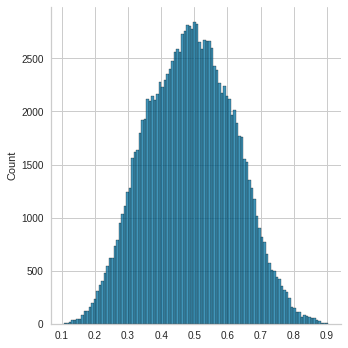

In [385]:
df_test_after_AutoML = df_test.copy()

df_test['pred'] = j

_ = sns.displot(i)

In [386]:
final_sub_after_AutoML = df_test_after_AutoML[['ID', 'pred']].copy()

final_sub_after_AutoML.to_csv('submission.csv', index=False)

### Test

In [389]:
df_val = df[df['Season'] == 2022]

In [390]:
prections = prep_pipe.predict_proba(df_val[features])

i, j = [], []
for row in prections:
  i.append(row[0])
  j.append(row[1])

len(i), len(j)

df_val['pred'] = j

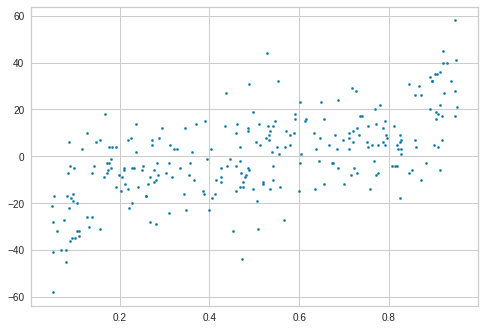

In [393]:
plt.scatter(df_val['pred'], df_val['ScoreDiff'].values, s=5)